In [1]:
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("monthly-beer-production-in-austr.csv")
data

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


In [3]:
data = data.dropna(axis=1, how='any')
data

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


In [4]:
data = data.set_index('Month')
data

,Monthly beer production
Month,
1956-01,93.2
1956-02,96.0
1956-03,95.2
1956-04,77.1
1956-05,70.9
...,...
1995-04,127.0
1995-05,151.0
1995-06,130.0


## Визуализация

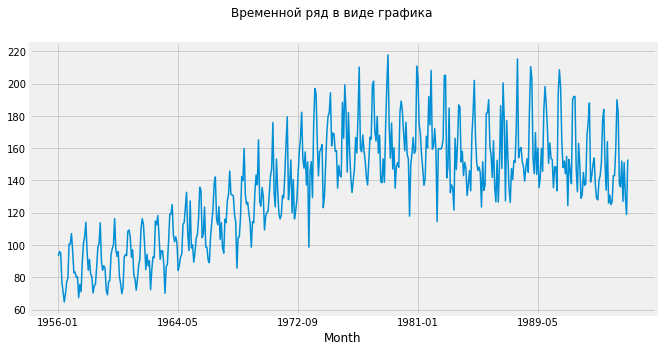

In [5]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
data.plot(ax=ax, legend=False)
pyplot.show()

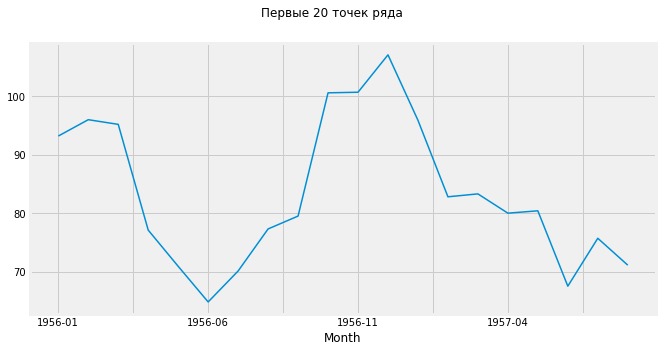

In [6]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Первые 20 точек ряда')
data[:20].plot(ax=ax, legend=False)
pyplot.show()

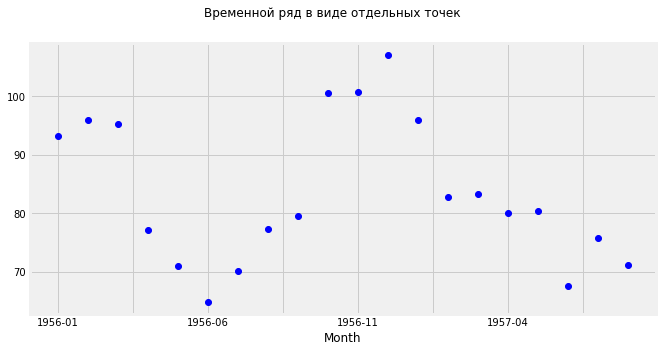

In [7]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде отдельных точек')
data[:20].plot(ax=ax, legend=False, style='bo')
pyplot.show()

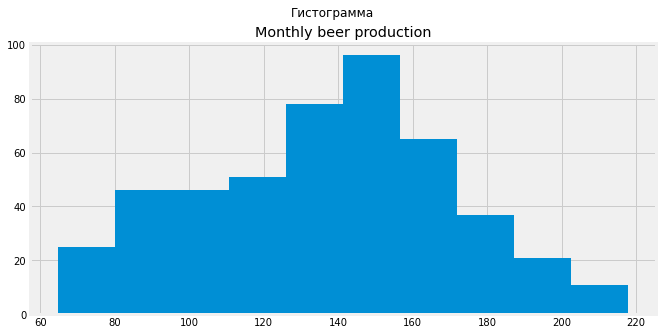

In [8]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Гистограмма')
data.hist(ax=ax, legend=False)
pyplot.show()

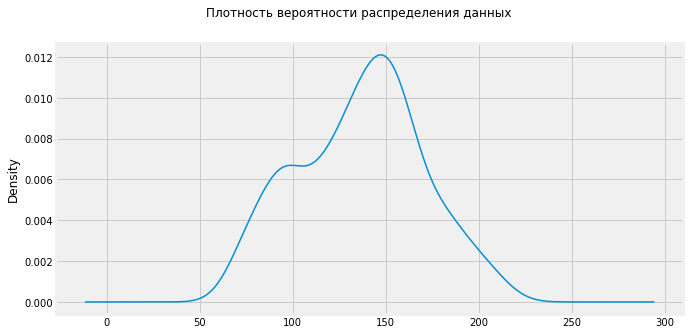

In [9]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Плотность вероятности распределения данных')
data.plot(ax=ax, kind='kde', legend=False)
pyplot.show()


## Разделение выборки на обучающую и тестовую

         Monthly beer production
Month                           
1956-01                     93.2
1956-02                     96.0
1956-03                     95.2
1956-04                     77.1
1956-05                     70.9
...                          ...
1995-04                    127.0
1995-05                    151.0
1995-06                    130.0
1995-07                    119.0
1995-08                    153.0

[476 rows x 1 columns]
Train dates : 1956-01 --- 1992-08  (n=440)
Test dates  : 1992-09 --- 1995-08  (n=36)


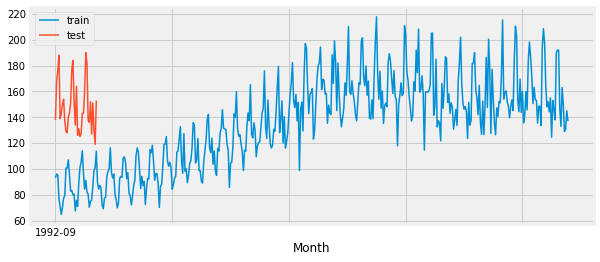

In [10]:
import matplotlib.pyplot as plt
steps = 36
# scaler = MinMaxScaler().fit(data_train[['open']])

# data['open'] = scaler.transform(data[['open']])
data_train = data[:-steps]
data_test  = data[-steps:]
print(data)


print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['Monthly beer production'].plot(ax=ax, label='train')
data_test['Monthly beer production'].plot(ax=ax, label='test')
ax.legend();

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score

def test_model(predictions):
    print('mean_absolute_error: {}'.format(round(mean_absolute_error(data_test['Monthly beer production'], predictions), 2)))
    print('median_absolute_error: {}'.format(round(median_absolute_error(data_test['Monthly beer production'], predictions), 2)))
    print('r2_score: {}'.format(round(r2_score(data_test['Monthly beer production'], predictions), 2)))

## Обучение моделей

### Skforecast-ForecasterAutoreg

In [12]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 7
                )

forecaster.fit(y=data_train['Monthly beer production'])
forecaster
steps = 36
predictions = forecaster.predict(steps=steps)

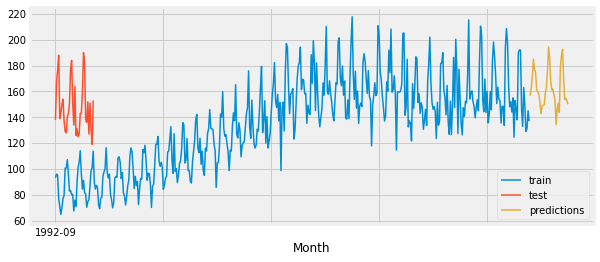

In [13]:
fig, ax2 = plt.subplots(figsize=(9, 4))
data_train['Monthly beer production'].plot(ax=ax2, label='train')
data_test['Monthly beer production'].plot(ax=ax2, label='test')
predictions.plot(ax=ax2, label='predictions')
ax2.legend();

In [14]:
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Monthly beer production'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [02:17<00:00, 68.73s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 287.781626185567



mean_absolute_error: 10.8
median_absolute_error: 8.55
r2_score: 0.5


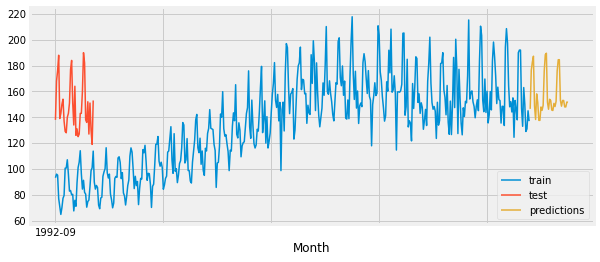

In [15]:
regressor = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['Monthly beer production'])
predictions = forecaster.predict(steps=steps)
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Monthly beer production'].plot(ax=ax, label='train')
data_test['Monthly beer production'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
test_model(predictions)

## Sarimax

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


mean_absolute_error: 13.49
median_absolute_error: 12.77
r2_score: 0.26


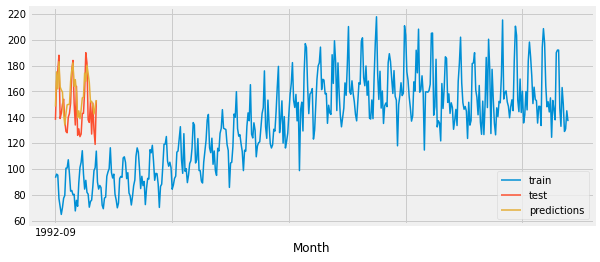

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

SARIMAXmodel = SARIMAX(data_train['Monthly beer production'], order = (3, 1, 3), seasonal_order=(3,1,5,22))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(data_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"]
fig, ax2 = plt.subplots(figsize=(9, 4))
data_train['Monthly beer production'].plot(ax=ax2, label='train')
data_test['Monthly beer production'].plot(ax=ax2, label='test')
y_pred_out.plot(ax=ax2, label='predictions')
ax2.legend()
test_model(y_pred_out)